In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm.auto import tqdm
import concurrent.futures
from multiprocessing import Pool
import copy,os,sys
from collections import Counter,deque
import itertools
import os
import time

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image
import pandas as pd
import subprocess
import dlib
from zac_pyutils import ExqUtils,CVUtils
from zac_pyutils.ConvertYolo import utils
import requests

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[2], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

3 Physical GPUs, 1 Logical GPU


# darknet编译

【事前准备】
```bash
git clone https://github.com/AlexeyAB/darknet
cd darknet
sed -i 's/OPENCV=0/OPENCV=1/' Makefile  # 把OPENCV打开
sed -i 's/GPU=0/GPU=1/' Makefile        # 把GPU打开
sed -i 's/CUDNN=0/CUDNN=1/' Makefile    # 把CUDNN打开

/usr/local/cuda/bin/nvcc --version      # 验证CUDA

make
```

【make阶段报错解决】
- 报错 `error: ‘for’ loop initial declarations are only allowed in C99 mode`
    - ~~进入 Makefile 找到CFLAGS的配置，追加 -std=c99~~
    - 大概157行有个 `$(CC) $(COMMON) $(CFLAGS) -c $< -o $@` 改为 `$(CC) $(COMMON) $(CFLAGS) -c -std=c99 $< -o $@`
    - 在开头修改CFLAGS不行因为诸如147、150行都用到了cpp (-std=c++11) 只有157用的是CC所以可以改为-std=c99
    - 注：nvcc不支持参数 `-std=c99` 的
    
- 报错 `sh: cicc: command not found`
    - cuda有两个compiler "front end", cicc是NVVM版本的 opencc是Open64版本的
    - 可以使用`locate cicc`全局查看`cicc`在哪，一般会在`/usr/local/cuda-9.0/nvvm/bin/cicc`
    - 加到`PATH`里即可
    
- 报错 `undefined reference to `timersub'`
    - 完整报错：
        ```bash
        obj/classifier.o: In function `threat_classifier':
        classifier.c:(.text+0x499e): undefined reference to `timersub'
        collect2: error: ld returned 1 exit status 
        ```
    - 这是需要给gcc加参数 `-D_BSD_SOURCE` 类似`-std=c99`
    - 大概在157行改为`$(CC) $(COMMON) $(CFLAGS) -c -std=c99 -D_BSD_SOURCE $< -o $@` 
    - 先查看`glibc`的版本`ldd --version`或者`getconf GNU_LIBC_VERSION`
        - [参考SO](https://stackoverflow.com/questions/33107237/implicit-declaration-of-timersub-function-in-linux-what-must-i-define) 
        - 2.20 版本`_BSD_SOURCE`被`_DEFAULT_SOURCE`替代了
        - 手头是 2.17 版本所要添加的就是`_BSD_SOURCE`

# darknet训练

【下载已有的weight】
```bash
wget https://pjreddie.com/media/files/yolov3.weights

```

【试运行】
```bash
cd ~/darknet
./darknet detect ./cfg/yolov3.cfg ./yolov3.weights ./data/person.jpg
# USAGE: ./darknet detect <path to config> <path to weights> <path to image>
# 会在此目录里生成一个 predictions.jpg
```

【训练数据】
- 用labelImg工具
- [参考这个YouTube视频](https://www.youtube.com/watch?v=EGQyDla8JNU)


【训练】
```bash
# 下载预训练权重
wget http://pjreddie.com/media/files/darknet53.conv.74

# 配置训练信息 obj.names, obj.data, train.txt
obj.names就是label.txt的形式，每一行是一个label
train.txt每一行是一个训练图片 xxx.jpg (每个文件在前面生成数据会有对应的label)
obj.data是一个配置文件
    classes = 3
    train = data/prepared_data/train.txt
    valid = data/prepared_data/test.txt
    names = data/obj.names
    backup = data/custom_weight  # 需要手动创建custom_weight目录

# 修改训练配置 cfg
cfg/custom_yolov3.cfg里修改 
classes=3, filters=(3+5)*3
# USAGE: In YoloV3 you have to change each filters= in 3 convolutional layers before [yolo] layer and classes in [yolo] layer. Formula is filters = (classes+5)*3 in yoloV3 (3 masks only)
batch=64, subdivision=16

# 执行训练 | 
cd ~/darknet
./darknet detector train data/obj.data cfg/custom_yolov3.cfg darknet53.conv.74 -dont_show
# USAGE: ./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
# 注意保留 -dont_show 参数不然没有GUI训练终止
# 会生成一个 charg.png 有训练信息
# For your model to be 'accurate' you would aim for a loss under 2.

【使用custom_weight】
# 需要修改cfg为test的模式，即batch=1 subdivision=1
sed -i 's/batch=64/batch=1/' cfg/custom_yolov3.cfg
sed -i 's/subdivisions=16/subdivisions=1/' cfg/custom_yolov3.cfg

# 使用 detector test 命令
# 自带的是 detect 指令 ./darknet detect ./cfg/yolov3.cfg ./yolov3.weights ./data/person.jpg
fp=/home/zhoutong/darknet/data/person.jpg
./darknet detector test data/obj.data cfg/custom_yolov3.cfg data/custom_weight/custom_yolov3_final.weights $fp -thresh 0.3

fp=/home/zhoutong/notebook_collection/tmp/CV_clf/nsfw/apus_samples/NSFW/5108bd180e284a28885390d993eea8ae.jpg
./darknet detector test data/obj.data cfg/custom_yolov3.cfg data/custom_weight/custom_yolov3_final.weights $fp -thresh 0.3

fp=/home/zhoutong/darknet/data/prepared_data/blowjob_11.jpg
./darknet detector test data/obj.data cfg/custom_yolov3.cfg data/custom_weight/custom_yolov3_final.weights $fp -thresh 0.3
```

训练自定义目标检测需要的yolov3.cg相关改动 | 参考[AlexeyAB官方说明](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects)
- classes=3
- batch=64, subdivision=16 | 记得注掉上面#Testing的batch和subdivision
- max_batches=600 (`classes*2000 but not less than 4000`)
- yolo层前一层的cnn filters=24 (`filters=(classes + 5)x3`)


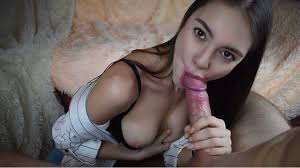

'\n#[bash cmd]\nfp=/home/zhoutong/darknet/data/prepared_data/blowjob_11.jpg\nweight=/home/zhoutong/darknet/data/custom_weight/custom_yolov3_final.weights\nobj_data=/home/zhoutong/darknet/data/obj.data\n#[darknet]\ncd ~/darknet\n!./darknet detector test $obj_data cfg/custom_yolov3.cfg $weight $fp -thresh 0.3\n[tf]\nnum_classes=3\nclasses=/home/zhoutong/darknet/data/obj.names\ntf_weight=/home/zhoutong/yolov3-tf2/checkpoints/yolov3.tf\ntf_weight=/home/zhoutong/darknet/data/custom_weight/custom_yolov3_final_ckpt\ncd ~/yolov3-tf2\n# python convert.py --weights $weight --output $tf_weight  --num_classes $num_classes\npython detect.py --image $fp --num_classes $num_classes --classes $classes --weights $tf_weight\n'

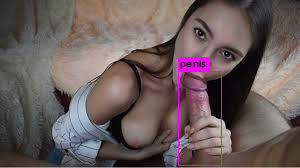

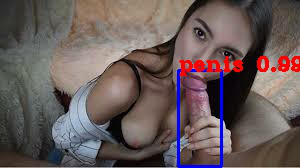

In [14]:
Image.open("/home/zhoutong/darknet/data/prepared_data/blowjob_11.jpg")
"""
#[bash cmd]
fp=/home/zhoutong/darknet/data/prepared_data/blowjob_11.jpg
weight=/home/zhoutong/darknet/data/custom_weight/custom_yolov3_final.weights
obj_data=/home/zhoutong/darknet/data/obj.data
#[darknet]
cd ~/darknet
!./darknet detector test $obj_data cfg/custom_yolov3.cfg $weight $fp -thresh 0.3
#[tf]
num_classes=3
classes=/home/zhoutong/darknet/data/obj.names
tf_weight=/home/zhoutong/darknet/data/custom_weight/custom_yolov3_final_ckpt
tf_pb=/home/zhoutong/darknet/data/custom_weight/custom_yolov3_final_pb
cd ~/yolov3-tf2
# [darknet.weight to tf.ckpt]
# python convert.py --weights $weight --output $tf_weight  --num_classes $num_classes
python detect.py --image $fp --num_classes $num_classes --classes $classes --weights $tf_weight
# [tf.ckpt to .pb]
cd ~/yolov3-tf2/tools
python export_tfserving.py --image $fp --num_classes $num_classes --classes $classes --weights $tf_weight --output $tf_pb
"""
Image.open("/home/zhoutong/darknet/predictions.jpg")
Image.open("/home/zhoutong/yolov3-tf2/output.jpg")


```bash
# darknet to tensorflow | utils.py & _Yolo_v3.py 目前放在GPU服务器的~/darkent里
python utils.py convert 4 /home/zhoutong/darknet/data/custom_weight/custom_yolov3_final.weights
```

In [5]:
from _Yolo_v3 import YoloV3
M = YoloV3(classes=3)
ckpt_fp=tf.train.latest_checkpoint("/home/zhoutong/darknet/data/custom_weight/")
print(ckpt_fp)
M.load_weights(ckpt_fp)
M.count_params()

/home/zhoutong/darknet/data/custom_weight/custom_yolov3_final_ckpt


61587112

# 加载pb模型文件

In [7]:
M=tf.saved_model.load("/home/zhoutong/darknet/data/custom_weight/custom_yolov3_final_pb")
infer = M.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
M

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f422709aac8>

# 测试模型

## 读取目录部分图片 带图测试标记

12

[TensorShape([12, 100, 4]), TensorShape([12, 100]), TensorShape([12, 100]), TensorShape([12])]


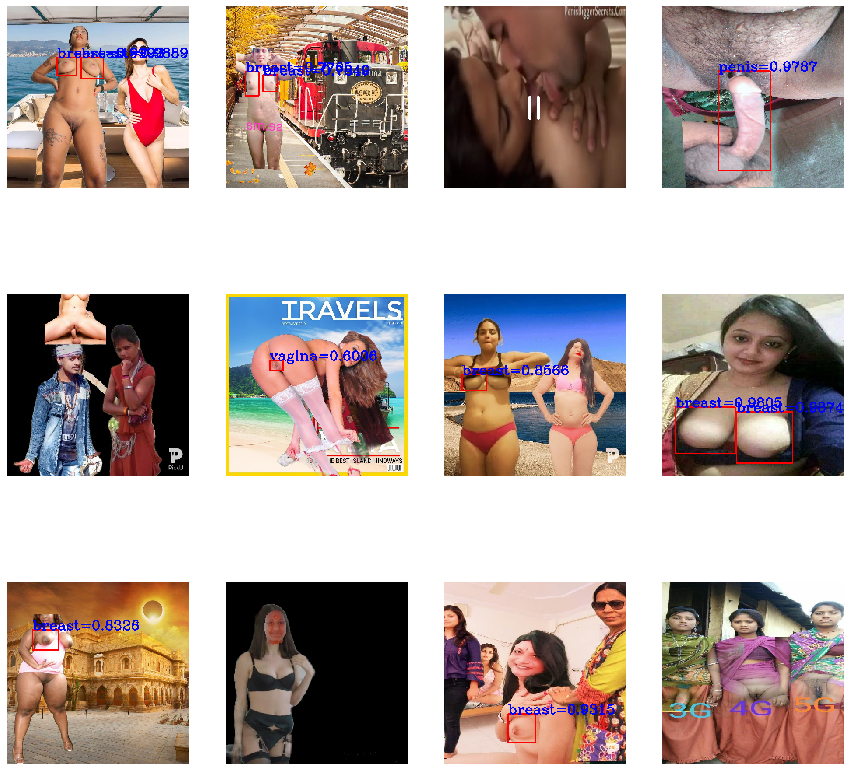

In [11]:
class_names=['penis','vagina','breast','ass']
IMAGE_SHAPE=(416,416)

fp_dir="/home/zhoutong/notebook_collection/tmp/CV_clf/nsfw/apus_samples/NSFW"
fp_list=[os.path.join(fp_dir,fp) for fp in os.listdir(fp_dir) if fp.endswith("jpg")]
fp_list=fp_list[8:20]
img_batch = [np.array(Image.open(fp).resize(IMAGE_SHAPE))/255. for fp in fp_list]
img_batch = np.array(img_batch)
len(img_batch)
img_batch_tensor = tf.convert_to_tensor(img_batch)
img_batch_tensor = tf.cast(img_batch_tensor,tf.float32)
# 注意这里pred的结果是一个list，每个list都是一个batch的结果
# 所以如果要取batch里的第idx个的结果应该是 [i[idx] for i in pred_batch]
# pred_batch = M.predict(img_batch)
pred_batch = M(img_batch_tensor)

print([i.shape for i in pred_batch])

img_draw = [utils.draw_outputs(img, [i[idx] for i in pred_batch], class_names) for idx,img in enumerate(img_batch)]

ExqUtils.pltshow(img_draw,figsize=(15,15))

## 读取目录所有图片测试

In [17]:
IMAGE_SHAPE=(416,416)
fp_dir="/home/zhoutong/notebook_collection/tmp/CV_clf/nsfw/apus_samples/NSFW"
fp_list=[os.path.join(fp_dir,fp) for fp in os.listdir(fp_dir) if fp.endswith("jpg")]
fp_list_iter=enumerate(fp_list)
import itertools as it
res=[]
while True:
    fp_list_batch=[fp for idx,fp in it.islice(fp_list_iter,64)]
    if len(fp_list_batch)>0:
        img_batch = [np.array(Image.open(fp).resize(IMAGE_SHAPE),dtype=np.float)/255 for fp in fp_list_batch]
        inp=tf.convert_to_tensor(img_batch)
        inp=tf.cast(inp, tf.float32)
        pred=infer(inp)
    #     boxes, objectness, classes, nums = pred
        res.append(pred)
    else:
        break

np.unique(np.concatenate([p['yolo_nms_3_3'].numpy() for p in res]),return_counts=True)

## 测试tfserving

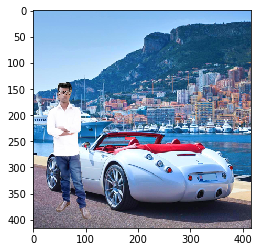

In [12]:
normal_pic="http://scd.cn.rfi.fr/sites/chinese.filesrfi/dynimagecache/0/0/660/372/1024/578/sites/images.rfi.fr/files/aef_image/_98711473_042934387-1.jpg"
normal_pic="https://static.picku.cloud/imageView2/material/7ad3fc32/202002/201020/1bdccf87526f4c3299f0aa97052daf82.jpg?mode=0"
normal_pic="https://static.picku.cloud/imageView2/material/7ad3fc32/202002/200857/6535e2b60d924c01b9a41120799d3307.jpg?mode=0"
normal_pic="https://static.picku.cloud/imageView2/material/7ad3fc32/202002/200646/db08018dd823432da5d244fdc8aa4f62.jpg?mode=0"
nsfw_pic="https://thumbor.apusapps.com/imageView2/material/7ad3fc32/201912/151247/49368788c67a4ed8b548371c15809bac.jpg"
imgPIL=CVUtils.Load.image_by_pil_from(normal_pic)
# imgPIL=CVUtils.Load.image_by_pil_from(nsfw_pic)
imgArr=np.array(imgPIL.resize((416,416)))/255
plt.imshow(imgArr)

In [13]:
tf_serving_url = 'http://10.65.34.65:18051/v1/models/ethnicity:predict'
tf_serving_url = 'http://10.65.34.65:18054/v1/models/nsfw_bcnn:predict'
tf_serving_url = 'http://10.65.34.65:18053/v1/models/nsfw_obj:predict'

data = json.dumps({"signature_name": "serving_default", "instances": [imgArr.tolist()]})
headers = {"content-type": "application/json"}
json_response = requests.post(tf_serving_url, data=data, headers=headers)
# json_response.text
pred_batch = json.loads(json_response.text)['predictions']
pred=pred_batch[0]
pred.keys()
# pred_batch[0]['yolo_nms_3']

dict_keys(['yolo_nms_1_1', 'yolo_nms_2_2', 'yolo_nms_0', 'yolo_nms_3_3'])

['yolo_nms_0', 'yolo_nms_1_1', 'yolo_nms_2_2', 'yolo_nms_3_3']

[(2, 0.602065146)]

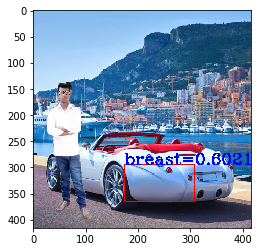

In [14]:
class_names=['penis','vagina','breast','ass']
kv_sorted=sorted([(k,v) for k,v in pred.items()],key=lambda x:x[0])
[kv[0] for kv in kv_sorted]
boxes,probs,classes,num=[v for k,v in kv_sorted]
label_prob_list=[(int(classes[i]),probs[i]) for i in range(num)]
label_prob_list
img_draw=utils.draw_outputs(imgArr,(boxes,probs,classes,num),class_names)
plt.imshow(img_draw)